<a href="https://colab.research.google.com/github/ASi-F/NLPlay-with-Transformers/blob/main/BERT_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT base

The BERT Transformer is available in 2 sizes- **base** and **large**. Here we train the smaller base version. It has **6 encoders** stacked on top of each other and gives an output embedding of dimension 768. Here we train the large model on a dataset of 7000 reviews and evaluate on a dataset of 3000 reviews by using **a Feed Forward Neural Network with 3 hidden layers and 500 neurons per layer architecture**. The output embeddings are processed by this neural network which is trained on this dataset.<br>
We have achieved an accuracy of 93.2% on the training set and 90.62% on the training set.<br>
Not BAD!

In [1]:
pip install transformers

In [2]:
pip install datasets

In [3]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import random 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Preprocessing**

The dataset is mounted from drive and some basic preprocessing is done to remove html tags. The review and sentiment columns are replaced by text and label columns. Here we convert the pandas df to dataset to pytorch dataloader

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLPlay/IMDB Dataset.csv')

In [6]:
def remove_tags(text):
    final = ""
    stt = True
    for char in text:
        if char == '<':
            stt = False
        if(stt):
            final = final + char
        if char == '>':
            stt = True
            final = final + ' '
    return final

df['text'] = df['review'].apply(remove_tags)

In [7]:
df = df.drop('review',axis = 1)

In [8]:
df['label'] = [ 1*(sent=='positive') for sent in df['sentiment']]

df = df.drop('sentiment', axis = 1)

In [9]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [10]:
train_range = [i for i in range(0,15000) if 6>=i%10 and i%10>=0]
eval_range = [i for i in range(0,15000) if 9>=i%10 and i%10>=7]

train_dataset = dataset.select(train_range).shuffle(seed=42)
eval_dataset = dataset.select(eval_range) .shuffle(seed=42)

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=10)
eval_dataloader = DataLoader(eval_dataset, batch_size=10)

## **Architecture**

In [12]:
from transformers import AutoModel
from transformers import AutoTokenizer

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [15]:
class Classifier(nn.Module):
  def __init__(self,hidden_dim,output_size,model_name,enc_dim):
    super(Classifier,self).__init__()

    self.model = AutoModel.from_pretrained(model_name, num_labels=2)
  
    self.LF1 = nn.Linear(enc_dim,hidden_dim)
    self.NLF1 = nn.ReLU()

    self.LF2 = nn.Linear(hidden_dim,hidden_dim)
    self.NLF2 = nn.ReLU()

    self.LF3 = nn.Linear(hidden_dim,output_size)

  def ready_train(self):
    (self.model).train()
  
  def ready_eval(self):
    self.model.eval()

  def forward(self,x):
    out = self.model(**x)[1]

    out = self.LF1(out)
    out = self.NLF1(out)

    out = self.LF2(out)
    out = self.NLF2(out)

    out = self.LF3(out)

    return F.softmax(out,dim=1)    

## **Training**

In [16]:
from tqdm.auto import tqdm

def train_classifier(num_epochs,train_dataloader,optimizer,classifier,tokenizer,loss_function = nn.CrossEntropyLoss()):
  losses = []
  num_training_steps = num_epochs*len(train_dataloader)
  progress_bar = tqdm(range(num_training_steps))
  classifier.ready_train()
  i = 0
  avg_loss = 0.
  for epoch in range(num_epochs):
    for batch in train_dataloader:
      # forward prop
      inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
      inp = inp.to(device)
      out = classifier(inp)
      pred = batch['label']
      pred = pred.to(device)
      loss = loss_function(out, pred)

      # backward prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
      progress_bar.update(1)
      if i%(5 *(num_training_steps//100)) == 0  and i>0:
        print("TRAINING:{0} %\t AVEREAGE LOSS: {1}".format(i//(num_training_steps//100),avg_loss/(5*(num_training_steps//100))))
        avg_loss = 0
      i+=1
      avg_loss = avg_loss + float(loss.item())
  return losses

## **Model Evaluation**

In [17]:
plt.rcParams['figure.figsize'] = (15,10)
plt.style.use('ggplot')

def plot_loss(losses):
  x = [i for i in range(0,len(losses))]
  plt.plot(x,losses)
  plt.title('Training Loss')
  plt.ylabel('Loss')
  plt.xlabel('Batch Index')

def smooth_loss(losses,f):
  y = [0]*len(losses)
  for i in range(0,f):
    y[i] = (sum(losses[:i+1+f]))/(i+1+f)
  for i in range(f,len(losses)-f-1):
    y[i] = (sum(losses[i-f:i+f+1]))/(2*f+1)
  for i in range(len(losses)-f-1,len(losses)):
    y[i] = (sum(losses[i-f:]))/(len(losses)-i+f)
  plot_loss(y)

In [18]:
def acc(dataloader,classifier,tokenizer):
  corr = 0
  tot = len(dataloader)*10
  for batch in dataloader:
  # forward prop
    inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
    inp = inp.to(device)
    out = list(torch.argmax(classifier(inp),dim=1))
    exp = list(batch['label'])
    
    for i,x in enumerate(out):
      if x == exp[i]:
        corr = corr+1
    
  return 100*(corr/tot)

## **Initialize model**

In [ ]:
model_name = 'bert-base-uncased'
output_size = 2
hidden_dim = 500
enc_dim = 768

bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier_bert = Classifier(hidden_dim,output_size,model_name,enc_dim)
classifier_bert.to(device)

In [20]:
num_epochs = 2
lr = 1e-2
optimizer = optim.SGD(classifier_bert.parameters(), lr)

losses = train_classifier(num_epochs,train_dataloader,optimizer,classifier_bert,bert_tokenizer)

  0%|          | 0/2100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


TRAINING:5 %	 AVEREAGE LOSS: 0.6909439671607245
TRAINING:10 %	 AVEREAGE LOSS: 0.6483354173955463
TRAINING:15 %	 AVEREAGE LOSS: 0.5874539517220997
TRAINING:20 %	 AVEREAGE LOSS: 0.5135477253368923
TRAINING:25 %	 AVEREAGE LOSS: 0.4655896788551694
TRAINING:30 %	 AVEREAGE LOSS: 0.46143209309805006
TRAINING:35 %	 AVEREAGE LOSS: 0.4388156283469427
TRAINING:40 %	 AVEREAGE LOSS: 0.4288950721422831
TRAINING:45 %	 AVEREAGE LOSS: 0.4482289359683082
TRAINING:50 %	 AVEREAGE LOSS: 0.441814295734678
TRAINING:55 %	 AVEREAGE LOSS: 0.4158608467805953
TRAINING:60 %	 AVEREAGE LOSS: 0.4233391753264836
TRAINING:65 %	 AVEREAGE LOSS: 0.4173467545282273
TRAINING:70 %	 AVEREAGE LOSS: 0.40867041519709996
TRAINING:75 %	 AVEREAGE LOSS: 0.42149810336884996
TRAINING:80 %	 AVEREAGE LOSS: 0.42249163616271246
TRAINING:85 %	 AVEREAGE LOSS: 0.4086860387098222
TRAINING:90 %	 AVEREAGE LOSS: 0.42035825820196243
TRAINING:95 %	 AVEREAGE LOSS: 0.41227636195364453


## **Plot for average loss per 100 iterations**

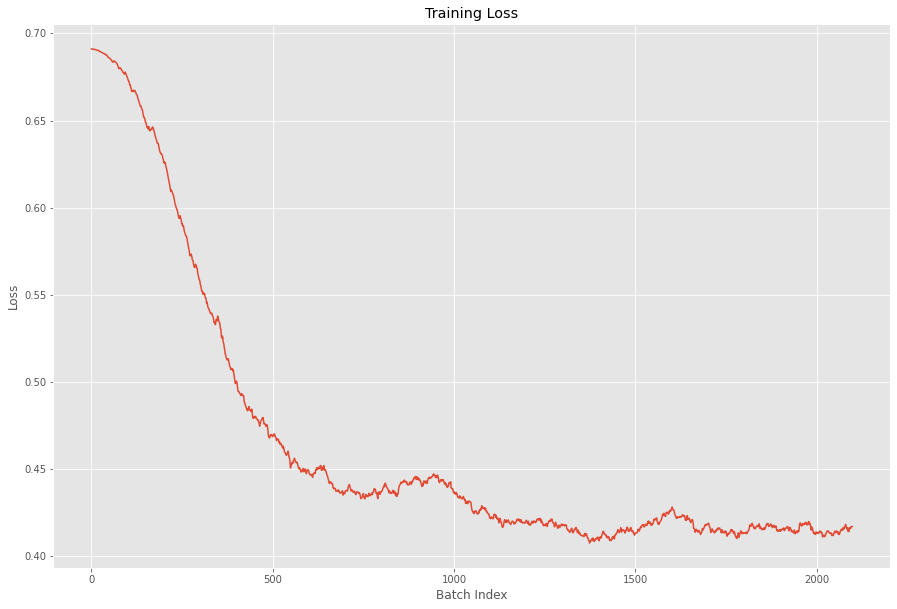

In [21]:
smooth_loss(losses,100)

## **Training set Accuracy**

In [22]:
classifier_bert.ready_eval()

In [23]:
acc(train_dataloader,classifier_bert,bert_tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


93.2

## **Test set accuracy**

In [24]:
acc(eval_dataloader,classifier_bert,bert_tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


90.62222222222222